## NHANES Glycohemoglobin data

Contents
1. Exploratory Data Analysis (EDA) and Data Cleaning
2. ML Models - Logistic Regression, Decision Tree, Random Forest
3. Fine-tuning of models

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from collections import Counter

seed = 42

In [2]:
file_path = './nhgh.tsv'
df = pd.read_csv(file_path, sep='\t')
df.head()

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
0,51624,male,34.166667,Non-Hispanic White,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94
1,51626,male,16.833333,Non-Hispanic Black,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89
2,51628,female,60.166667,Non-Hispanic Black,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11
3,51629,male,26.083333,Mexican American,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80
4,51630,female,49.666667,Non-Hispanic White,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79


### Exploratory Data Analysis & Data Cleaning

We want to check the quality of the data as it will impact downstream analysis. Namely, we will be looking at the distribution of data variables, possible relationships between variables, and also check for inconsistencies e.g. outliers, missing values, duplicate values etc.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6795 entries, 0 to 6794
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   seqn     6795 non-null   int64  
 1   sex      6795 non-null   object 
 2   age      6795 non-null   float64
 3   re       6795 non-null   object 
 4   income   6475 non-null   object 
 5   tx       6795 non-null   int64  
 6   dx       6795 non-null   int64  
 7   wt       6795 non-null   float64
 8   ht       6795 non-null   float64
 9   bmi      6795 non-null   float64
 10  leg      6564 non-null   float64
 11  arml     6616 non-null   float64
 12  armc     6607 non-null   float64
 13  waist    6556 non-null   float64
 14  tri      6314 non-null   float64
 15  sub      5824 non-null   float64
 16  gh       6795 non-null   float64
 17  albumin  6706 non-null   float64
 18  bun      6706 non-null   float64
 19  SCr      6706 non-null   float64
dtypes: float64(14), int64(3), object(3)
memory usage: 1.

Let's understand what kind of variables we're dealing with:

Discrete variables
- tx
- dx

Continuous variables
- age
- wt
- ht
- bmi
- leg
- arml
- armc
- waist
- tri
- sub
- gh
- albumin
- bun
- SCr

Nominal variables
- seqn
- sex
- re

Ordinal variables
- income

In [4]:
df = df.drop(columns=['seqn'])

In [5]:
df[df.duplicated()]

,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr


No duplicated observations. Now we check for missing data

In [6]:
df.isnull().sum().sort_values(ascending=False)

sub        971
tri        481
income     320
waist      239
leg        231
armc       188
arml       179
SCr         89
bun         89
albumin     89
sex          0
re           0
age          0
ht           0
wt           0
tx           0
bmi          0
dx           0
gh           0
dtype: int64

When deciding whether or not to drop columns or rows with missing values, we take into account the percentage of NaNs to gauge if a column/row has enough information. Assume an arbitrary threshold of 60%, where if a column/row is missing >= 60% of data, we discard them.

`sub` has the highest number of NaNs (around 14.3% observations missing). Given the 60% threshold, we do not drop any columns. 

Note that `bun`, `albumin`, and `SCr` all have the same number of observations (89) missing these values. It may be the case that an observation is missing all 3 of these values at the same time

In [7]:
df[df.isnull().any(axis=1)]

,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
9,female,43.000000,Non-Hispanic Black,"[35000,45000)",1,1,107.7,164.3,39.90,32.7,36.5,39.6,129.8,27.0,NaN,11.0,3.6,16.0,2.54
10,male,66.416667,Mexican American,"[5000,10000)",0,0,82.9,171.3,28.25,NaN,NaN,NaN,NaN,NaN,NaN,5.7,4.4,9.0,0.86
13,female,19.333333,Non-Hispanic Black,"[20000,25000)",0,0,111.6,165.7,40.65,38.5,35.6,40.5,117.4,NaN,NaN,6.2,4.1,9.0,0.71
20,male,32.833333,Mexican American,"[25000,35000)",0,0,85.7,159.5,33.69,35.0,37.0,32.6,105.3,20.6,NaN,6.0,4.4,8.0,0.72
30,female,27.916667,Non-Hispanic White,"[45000,55000)",0,0,105.8,149.7,47.21,NaN,NaN,NaN,NaN,NaN,NaN,5.2,4.0,10.0,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6761,female,17.750000,Non-Hispanic Black,"[5000,10000)",0,0,104.8,168.5,36.91,42.0,37.0,42.5,119.5,NaN,NaN,9.5,4.2,6.0,0.58
6763,female,58.333333,Other Hispanic,"[10000,15000)",1,1,53.7,147.9,24.55,34.3,32.2,26.2,84.7,23.2,NaN,6.3,4.4,15.0,0.70
6776,male,70.333333,Mexican American,"[5000,10000)",0,0,90.5,166.0,32.84,NaN,NaN,NaN,NaN,NaN,NaN,5.7,3.7,8.0,0.78
6790,male,33.000000,Mexican American,"[35000,45000)",0,0,94.3,163.5,35.28,34.4,34.7,35.5,112.3,20.2,NaN,5.4,4.1,10.0,0.97


1452 observations missing at least one value. We check in detail if any row has more than 60% of missing values

In [8]:
df[df.isnull().sum(axis=1) >= (0.6*20)]

,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr


We do not need to drop any rows. The missing values may be imputed later on.

In [9]:
df[df.isnull().sum(axis=1) >= (0.4*20)]

,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
1438,female,70.416667,Non-Hispanic Black,"[45000,55000)",1,1,160.7,158.6,63.89,NaN,NaN,NaN,NaN,NaN,NaN,5.4,NaN,NaN,NaN
1837,female,72.916667,Non-Hispanic White,>= 100000,1,1,152.0,152.7,65.19,NaN,NaN,NaN,NaN,NaN,NaN,5.5,NaN,NaN,NaN
3415,female,80.000000,Non-Hispanic Black,"[10000,15000)",0,0,76.6,151.7,33.29,NaN,NaN,NaN,NaN,NaN,NaN,4.4,NaN,NaN,NaN
4218,female,43.083333,Non-Hispanic Black,"[20000,25000)",1,1,80.3,169.4,27.98,NaN,NaN,NaN,NaN,NaN,NaN,8.3,NaN,NaN,NaN
5081,female,25.833333,Other Race Including Multi-Racial,>= 100000,0,0,52.1,153.9,22.00,NaN,NaN,NaN,NaN,NaN,NaN,5.3,NaN,NaN,NaN
6509,male,78.166667,Other Hispanic,"[5000,10000)",0,0,73.6,159.5,28.93,NaN,NaN,NaN,NaN,NaN,NaN,7.3,NaN,NaN,NaN


These observations have 45% missing data

Let's explore the target variable, `gh` where values >=6.5 indicates person has diabetes, and <6.5 otherwise

<Axes: xlabel='gh'>

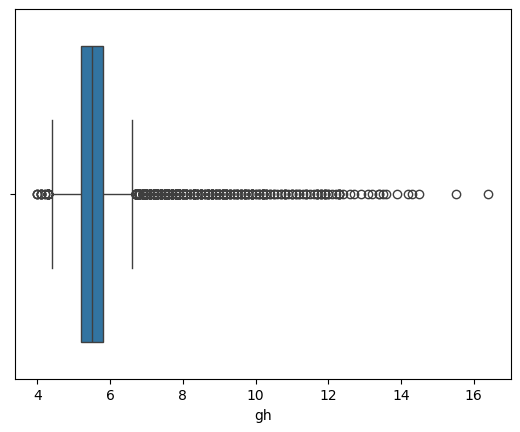

In [10]:
sns.boxplot(data=df, x='gh')

<Axes: xlabel='gh', ylabel='Count'>

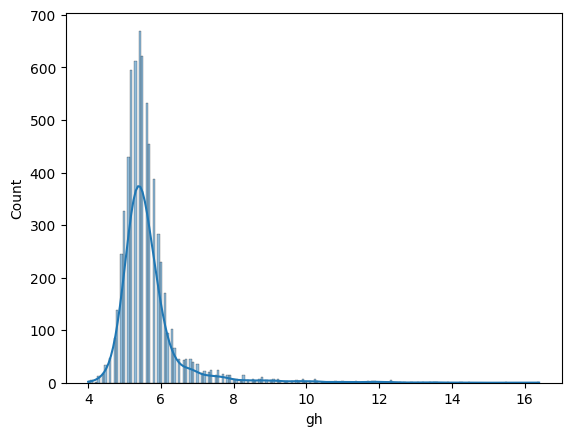

In [11]:
sns.histplot(data=df, x='gh', kde=True)

In [12]:
df['gh'].describe()

count    6795.000000
mean        5.676586
std         0.964700
min         4.000000
25%         5.200000
50%         5.500000
75%         5.800000
max        16.400000
Name: gh, dtype: float64

It appears that majority of the observations do not have diabetes. We do not remove outliers as they indicate disease. From the distribution, we can expect an imbalanced dataset where the 'Diabetes' class has very few observations. Later on, we will add the `gh_cat` column such that 0 indicates No Diabetes and 1 indicates Diabetes, a categorical way of representing `gh`

Let's explore the nominal and ordinal variables first as we will need to represent them in some numerical form as a way of data preprocessing

For nominal variables such as `sex` and `re`, we use One Hot Encoding

For ordinal variable `income`, we use Label Encoding

In [13]:
df['sex'].unique()

array(['male', 'female'], dtype=object)

In [14]:
sex_counts = df['sex'].value_counts().to_dict()
counts = [sex_counts['male'], sex_counts['female']]
print(sex_counts)
print(counts)

{'female': 3423, 'male': 3372}
[3372, 3423]


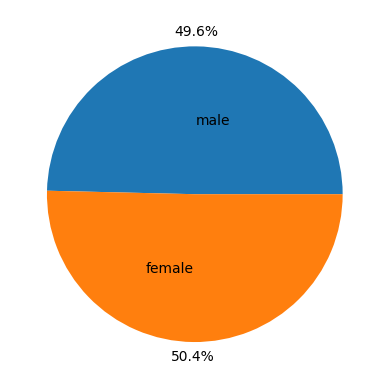

In [15]:
plt.pie(counts, labels=['male', 'female'], autopct='%1.1f%%', pctdistance=1.1, labeldistance=.5)
plt.show()

In [16]:
df = pd.get_dummies(df, prefix=['sex'], columns=['sex'], dtype='int')
df

,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr,sex_female,sex_male
0,34.166667,Non-Hispanic White,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94,0,1
1,16.833333,Non-Hispanic Black,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89,0,1
2,60.166667,Non-Hispanic Black,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11,1,0
3,26.083333,Mexican American,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80,0,1
4,49.666667,Non-Hispanic White,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,33.000000,Mexican American,"[35000,45000)",0,0,94.3,163.5,35.28,34.4,34.7,35.5,112.3,20.2,NaN,5.4,4.1,10.0,0.97,0,1
6791,48.916667,Non-Hispanic White,"[0,5000)",0,1,87.1,156.9,35.38,33.9,34.5,37.0,99.4,28.6,25.4,5.5,4.1,7.0,0.89,1,0
6792,27.500000,Other Hispanic,"[35000,45000)",0,0,57.0,164.3,21.12,35.3,33.7,29.6,73.2,4.2,6.8,5.6,4.5,11.0,0.94,0,1
6793,75.750000,Non-Hispanic Black,"[10000,15000)",0,0,75.1,162.7,28.37,38.6,36.8,31.2,104.0,19.8,21.1,5.4,4.0,19.0,1.34,0,1


In [17]:
print(df['re'].unique())
print(len(df['re'].unique()))

['Non-Hispanic White' 'Non-Hispanic Black' 'Mexican American'
 'Other Hispanic' 'Other Race Including Multi-Racial']
5


In [18]:
re_counts = df['re'].value_counts().to_dict()
re_types = list(re_counts.keys())
counts = []
for k in re_types:
    counts.append(re_counts[k])
print(re_counts)
print(counts)

{'Non-Hispanic White': 3117, 'Mexican American': 1366, 'Non-Hispanic Black': 1217, 'Other Hispanic': 706, 'Other Race Including Multi-Racial': 389}
[3117, 1366, 1217, 706, 389]


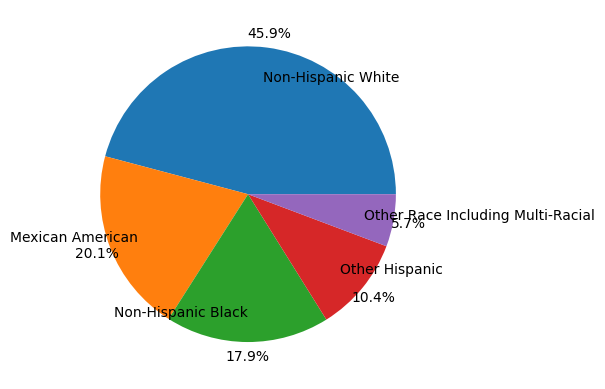

In [19]:
plt.pie(counts, labels=re_types, autopct='%1.1f%%', pctdistance=1.1, labeldistance=.8)
plt.show()

In [20]:
df = pd.get_dummies(df, prefix=['re'], columns=['re'], dtype='int')
df

,age,income,tx,dx,wt,ht,bmi,leg,arml,armc,...,albumin,bun,SCr,sex_female,sex_male,re_Mexican American,re_Non-Hispanic Black,re_Non-Hispanic White,re_Other Hispanic,re_Other Race Including Multi-Racial
0,34.166667,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,...,4.8,6.0,0.94,0,1,0,0,1,0,0
1,16.833333,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,...,4.6,9.0,0.89,0,1,0,1,0,0,0
2,60.166667,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,...,3.9,10.0,1.11,1,0,0,1,0,0,0
3,26.083333,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,...,4.2,8.0,0.80,0,1,1,0,0,0,0
4,49.666667,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,...,4.3,13.0,0.79,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,33.000000,"[35000,45000)",0,0,94.3,163.5,35.28,34.4,34.7,35.5,...,4.1,10.0,0.97,0,1,1,0,0,0,0
6791,48.916667,"[0,5000)",0,1,87.1,156.9,35.38,33.9,34.5,37.0,...,4.1,7.0,0.89,1,0,0,0,1,0,0
6792,27.500000,"[35000,45000)",0,0,57.0,164.3,21.12,35.3,33.7,29.6,...,4.5,11.0,0.94,0,1,0,0,0,1,0
6793,75.750000,"[10000,15000)",0,0,75.1,162.7,28.37,38.6,36.8,31.2,...,4.0,19.0,1.34,0,1,0,1,0,0,0


In [21]:
print(df['income'].unique())
print(len(df['income'].unique()))

['[25000,35000)' '[45000,55000)' '[10000,15000)' '[35000,45000)'
 '[15000,20000)' '[75000,100000)' '[5000,10000)' '[0,5000)'
 '[20000,25000)' '>= 100000' '[65000,75000)' '> 20000' nan '[55000,65000)'
 '< 20000']
15


C:\Users\jacin\AppData\Local\Temp\ipykernel_20892\4232833790.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


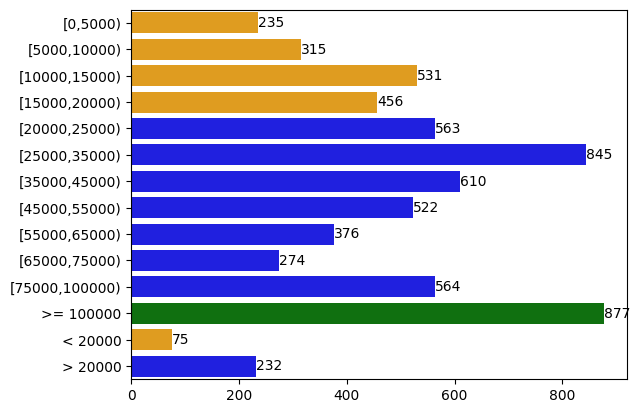

In [22]:
income_count = df['income'].value_counts().to_dict()
income_types = [
    '[0,5000)',
    '[5000,10000)',
    '[10000,15000)',
    '[15000,20000)',
    '[20000,25000)',
    '[25000,35000)',
    '[35000,45000)',
    '[45000,55000)',
    '[55000,65000)',
    '[65000,75000)',
    '[75000,100000)',
    '>= 100000',
    '< 20000',
    '> 20000'
]
income_palette = []
for i in range(4):
    income_palette.append('orange')
for i in range(7):
    income_palette.append('blue')
income_palette.append('green')
income_palette.append('orange')
income_palette.append('blue')
counts = []
for k in income_types:
    counts.append(income_count[k])
ax = sns.barplot(
    x=counts,
    y=income_types,
    orient='h',
    palette=income_palette
)
for i in ax.containers:
    ax.bar_label(i,)

`income` is trickier to clean because we have two levels '< 20000' and '> 20000' which overlap with some other levels, as colour coded by orange and blue respectively. Further, I assume that '> 20000' means '> 20000 and < 100000' due to the presence of the '>= 100000' level. 

There are a few options to consider to deal with the overlap in levels. First, turn '< 20000' and '> 20000' into a new level or incorporate into one of the existing levels e.g. assign '< 20000' to the mode/median of overlapping levels '[10000,15000)'. This will affect the distribution of data. Second, discard '< 20000' and '> 20000' due to ambiguity. However, this will result in information loss. 

'< 20000' accounts for 4.88% of all overlapping levels while '> 20000' accounts for 6.18% of all overlapping levels. Since 4.88% and 6.18% are relatively small, we consider the first option and assign '< 20000' and '> 20000' to the median overlapping classes which are '[10000,15000)' and '[35000,45000)' respectively.

In [23]:
def income_to_num(row, flag):
    income_dict = {
        '[0,5000)':1,
        '[5000,10000)':2,
        '[10000,15000)':3,
        '[15000,20000)':4,
        '[20000,25000)':5,
        '[25000,35000)':6,
        '[35000,45000)':7,
        '[45000,55000)':8,
        '[55000,65000)':9,
        '[65000,75000)':10,
        '[75000,100000)':11,
        '>= 100000':12,
        '< 20000':3,
        '> 20000':7,
        }
    if flag and row['income'] in income_dict:
        if row['income'] == '< 20000' or row['income'] == '> 20000':
            return np.nan
        else:
            return income_dict[row['income']]
    elif row['income'] in income_dict:
        return income_dict[row['income']]
    else:
        return np.nan

df['income_tmp'] = df.apply(lambda row: income_to_num(row, True), axis=1)
df['income_new'] = df.apply(lambda row: income_to_num(row, False), axis=1)
df

,age,income,tx,dx,wt,ht,bmi,leg,arml,armc,...,SCr,sex_female,sex_male,re_Mexican American,re_Non-Hispanic Black,re_Non-Hispanic White,re_Other Hispanic,re_Other Race Including Multi-Racial,income_tmp,income_new
0,34.166667,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,...,0.94,0,1,0,0,1,0,0,6.0,6.0
1,16.833333,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,...,0.89,0,1,0,1,0,0,0,8.0,8.0
2,60.166667,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,...,1.11,1,0,0,1,0,0,0,3.0,3.0
3,26.083333,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,...,0.80,0,1,1,0,0,0,0,6.0,6.0
4,49.666667,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,...,0.79,1,0,0,0,1,0,0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,33.000000,"[35000,45000)",0,0,94.3,163.5,35.28,34.4,34.7,35.5,...,0.97,0,1,1,0,0,0,0,7.0,7.0
6791,48.916667,"[0,5000)",0,1,87.1,156.9,35.38,33.9,34.5,37.0,...,0.89,1,0,0,0,1,0,0,1.0,1.0
6792,27.500000,"[35000,45000)",0,0,57.0,164.3,21.12,35.3,33.7,29.6,...,0.94,0,1,0,0,0,1,0,7.0,7.0
6793,75.750000,"[10000,15000)",0,0,75.1,162.7,28.37,38.6,36.8,31.2,...,1.34,0,1,0,1,0,0,0,3.0,3.0


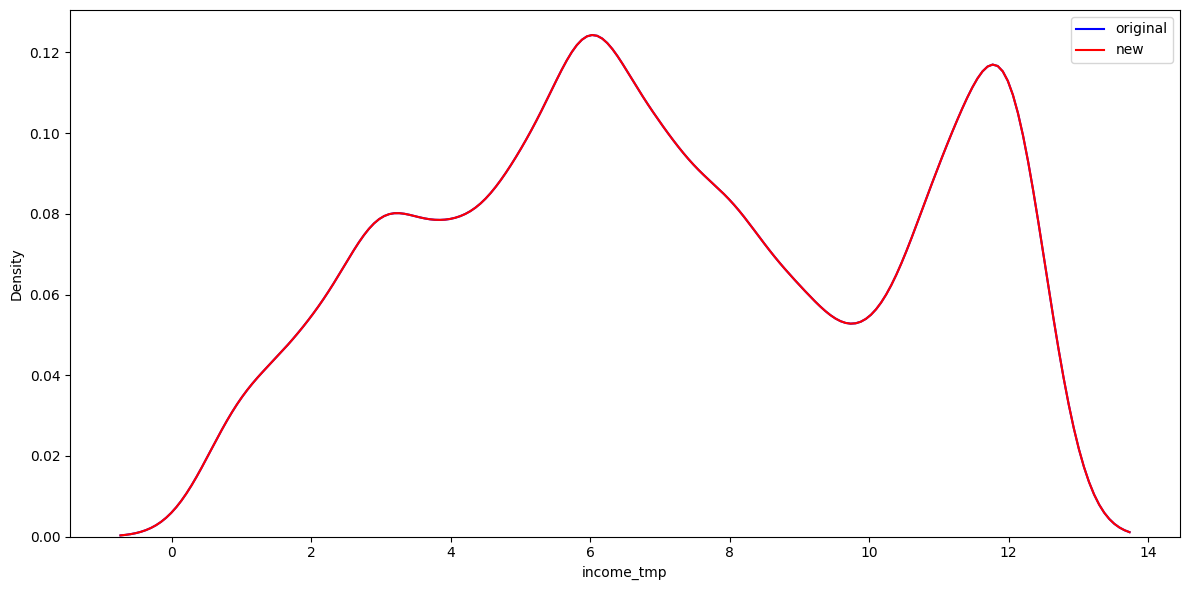

In [24]:
tmp = df[['income_tmp', 'income_new']]
tmp = tmp.dropna()
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=tmp, x='income_tmp', color='blue', label='original', ax=ax)
sns.kdeplot(data=tmp, x='income_new', color='red', label='new', ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

From the density plots of `income` before and after label encoding, we see that the distributions are highly similar and overlap exactly. Hence incorporating '< 20000' and '> 20000' into existing levels does not significantly change the original data distribution of `income`

In [25]:
df = df.drop(columns=['income_tmp', 'income'])
df = df.rename(columns={'income_new':'income'})
df

,age,tx,dx,wt,ht,bmi,leg,arml,armc,waist,...,bun,SCr,sex_female,sex_male,re_Mexican American,re_Non-Hispanic Black,re_Non-Hispanic White,re_Other Hispanic,re_Other Race Including Multi-Racial,income
0,34.166667,0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,...,6.0,0.94,0,1,0,0,1,0,0,6.0
1,16.833333,0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,...,9.0,0.89,0,1,0,1,0,0,0,8.0
2,60.166667,1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,...,10.0,1.11,1,0,0,1,0,0,0,3.0
3,26.083333,0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,...,8.0,0.80,0,1,1,0,0,0,0,6.0
4,49.666667,0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,...,13.0,0.79,1,0,0,0,1,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,33.000000,0,0,94.3,163.5,35.28,34.4,34.7,35.5,112.3,...,10.0,0.97,0,1,1,0,0,0,0,7.0
6791,48.916667,0,1,87.1,156.9,35.38,33.9,34.5,37.0,99.4,...,7.0,0.89,1,0,0,0,1,0,0,1.0
6792,27.500000,0,0,57.0,164.3,21.12,35.3,33.7,29.6,73.2,...,11.0,0.94,0,1,0,0,0,1,0,7.0
6793,75.750000,0,0,75.1,162.7,28.37,38.6,36.8,31.2,104.0,...,19.0,1.34,0,1,0,1,0,0,0,3.0


Now that our ordinal variable is label encoded, let's explore the correlations between some variables

<Axes: >

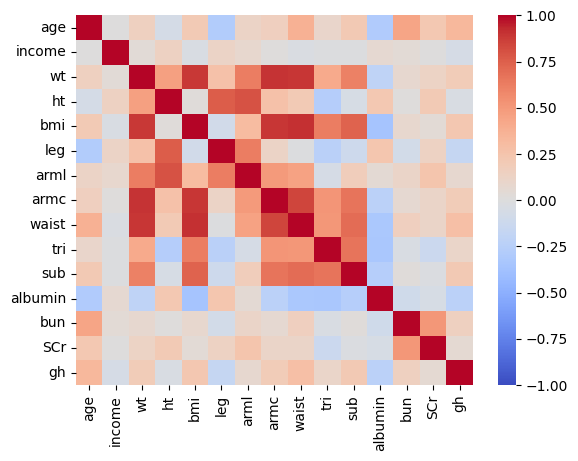

In [26]:
ordinal_cts = ['age','income', 'wt', 'ht', 'bmi', 'leg', 'arml', 'armc', 'waist', 'tri', 'sub', 'albumin', 'bun', 'SCr', 'gh']
sns.heatmap(
    df[ordinal_cts].corr(),
    vmin=-1, vmax=1,
    annot=False,
    cmap='coolwarm'
)

`bmi` has strong positive correlation with the variables `wt`, `armc`, and `waist`. Since `wt` is used to calculate `bmi`, the strong positive correlation is not surprising; a higher weight indicates higher bmi assuming height is constant. It is interesting that for `armc` and `waist` which are not used to calculate bmi were observed to have strong positive correlation with `bmi`. This may be useful in inferring missing values from `armc` and `waist` based on their strong linear relationship with `bmi`.

In [27]:
df.isnull().sum().sort_values(ascending=False)

sub                                     971
tri                                     481
income                                  320
waist                                   239
leg                                     231
armc                                    188
arml                                    179
albumin                                  89
SCr                                      89
bun                                      89
ht                                        0
bmi                                       0
tx                                        0
age                                       0
dx                                        0
wt                                        0
gh                                        0
sex_female                                0
re_Mexican American                       0
sex_male                                  0
re_Non-Hispanic Black                     0
re_Non-Hispanic White                     0
re_Other Hispanic               

In [28]:
df[df['albumin'].isnull() & df['SCr'].isnull() & df['bun'].isnull()]

,age,tx,dx,wt,ht,bmi,leg,arml,armc,waist,...,bun,SCr,sex_female,sex_male,re_Mexican American,re_Non-Hispanic Black,re_Non-Hispanic White,re_Other Hispanic,re_Other Race Including Multi-Racial,income
116,31.416667,0,0,76.2,169.1,26.65,41.0,37.8,31.2,87.2,...,NaN,NaN,1,0,1,0,0,0,0,9.0
130,12.416667,0,0,45.9,156.3,18.79,35.2,33.7,22.4,76.0,...,NaN,NaN,1,0,1,0,0,0,0,3.0
183,76.916667,1,1,79.6,161.3,30.59,33.0,33.1,35.0,105.4,...,NaN,NaN,0,1,0,1,0,0,0,7.0
238,54.000000,1,1,70.8,156.5,28.91,36.0,37.2,35.7,99.2,...,NaN,NaN,1,0,1,0,0,0,0,6.0
425,80.000000,1,1,61.4,149.3,27.55,32.4,34.2,28.9,99.6,...,NaN,NaN,1,0,0,0,0,1,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6440,39.000000,0,0,89.8,167.5,32.01,35.5,34.6,31.8,105.4,...,NaN,NaN,1,0,0,0,1,0,0,5.0
6480,59.083333,0,0,99.5,181.8,30.10,44.9,38.2,33.6,107.7,...,NaN,NaN,0,1,0,0,1,0,0,12.0
6493,80.000000,0,0,76.2,159.3,30.03,35.5,37.3,33.2,101.3,...,NaN,NaN,1,0,0,0,1,0,0,10.0
6509,78.166667,0,0,73.6,159.5,28.93,NaN,NaN,NaN,NaN,...,NaN,NaN,0,1,0,0,0,1,0,2.0


True to assumption, `albumin`, `bun`, and `SCr` are missing together for the 89 observations. This may be related to how the data was collected for the 3 variables such as absence of a specific blood/urine test, hence it can be classified as missing not at random.

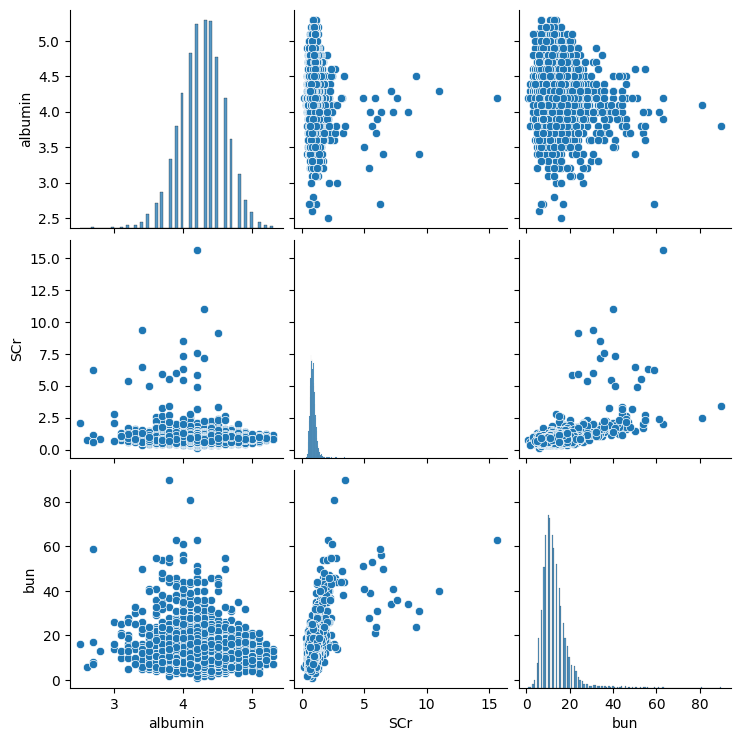

In [29]:
sns.pairplot(
    data=df,
    vars=['albumin', 'SCr', 'bun'],
)

<Axes: xlabel='albumin'>

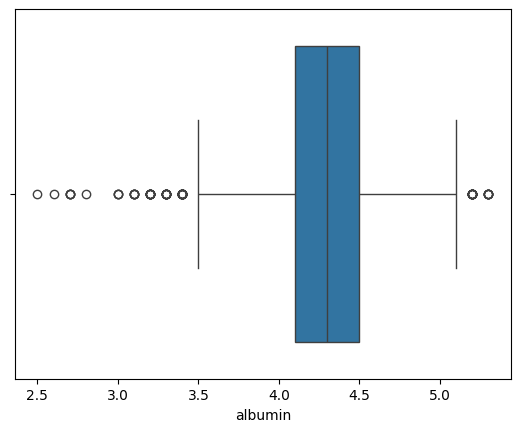

In [30]:
sns.boxplot(data=df, x='albumin')

<Axes: xlabel='albumin', ylabel='Count'>

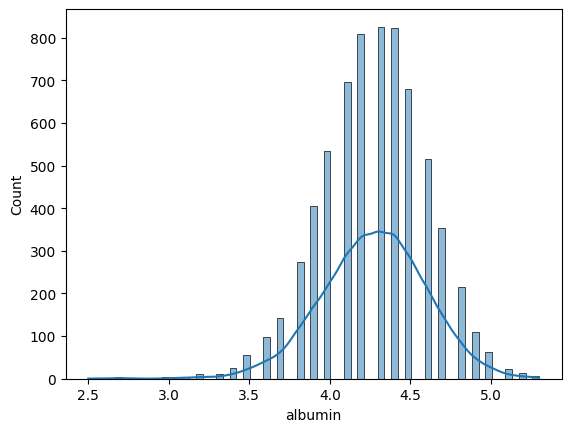

In [31]:
sns.histplot(data=df, x='albumin', kde=True)

In [32]:
df['albumin'].describe()

count    6706.000000
mean        4.273621
std         0.326545
min         2.500000
25%         4.100000
50%         4.300000
75%         4.500000
max         5.300000
Name: albumin, dtype: float64

<Axes: xlabel='SCr'>

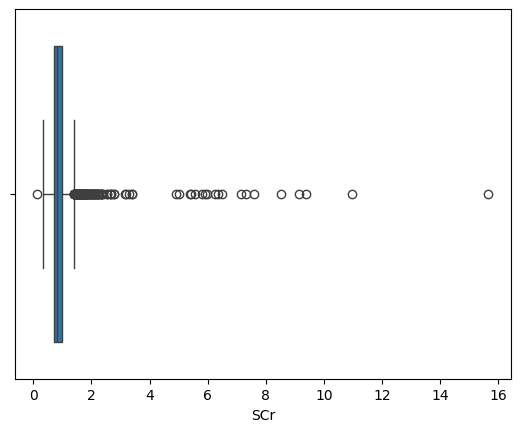

In [33]:
sns.boxplot(data=df, x='SCr')

<Axes: xlabel='SCr', ylabel='Count'>

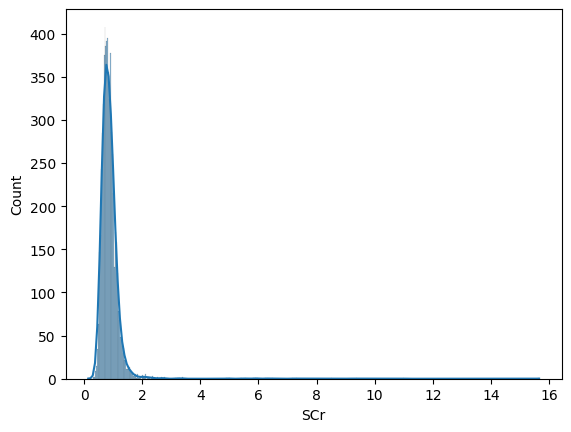

In [34]:
sns.histplot(data=df, x='SCr', kde=True)

In [35]:
df['SCr'].describe()

count    6706.000000
mean        0.878627
std         0.445238
min         0.140000
25%         0.700000
50%         0.830000
75%         0.980000
max        15.660000
Name: SCr, dtype: float64

<Axes: xlabel='bun'>

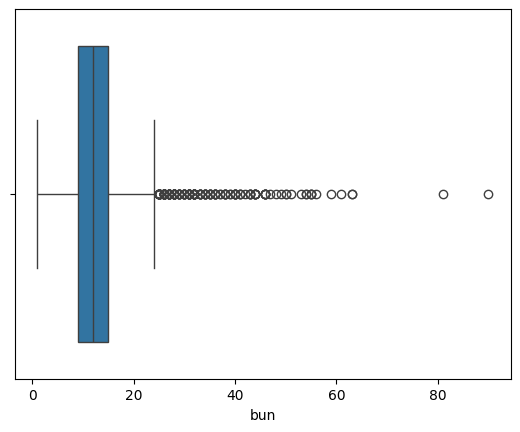

In [36]:
sns.boxplot(data=df, x='bun')

<Axes: xlabel='bun', ylabel='Count'>

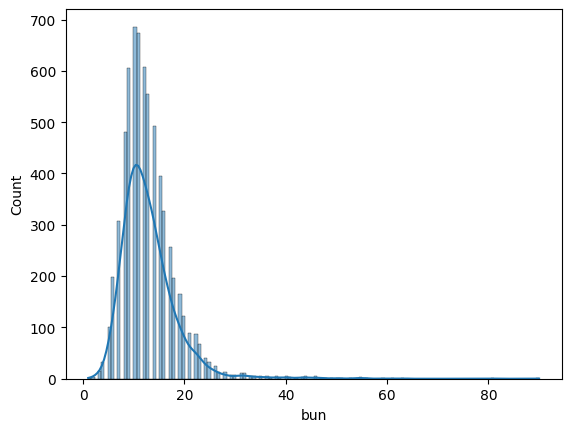

In [37]:
sns.histplot(data=df, x='bun', kde=True)

In [38]:
df['bun'].describe()

count    6706.000000
mean       12.917686
std         5.717571
min         1.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        90.000000
Name: bun, dtype: float64

The distributions of `SCr` and `bun` indicate that majority of observations lie in an acceptable range with some outliers. The outliers may indicate signs of disease and thus should not be dropped. It is also not as straightforward to impute missing values with the mean/median as the observation might have diabetes based on the values of the other variables and thus might have a much higher `albumin` or `SCr` or `bun` value than expected. We use multivariate imputation to fill in missing values in this dataset.

In [39]:
imp = IterativeImputer(
    max_iter=15,
    random_state=seed
)
imp.fit(df)

IterativeImputer(max_iter=15, random_state=42)

In [40]:
df_imp = pd.DataFrame(imp.transform(df), columns=df.columns)
df_imp

,age,tx,dx,wt,ht,bmi,leg,arml,armc,waist,...,bun,SCr,sex_female,sex_male,re_Mexican American,re_Non-Hispanic Black,re_Non-Hispanic White,re_Other Hispanic,re_Other Race Including Multi-Racial,income
0,34.166667,0.0,0.0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,...,6.0,0.94,0.0,1.0,0.0,0.0,1.0,0.0,0.0,6.000000
1,16.833333,0.0,0.0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,...,9.0,0.89,0.0,1.0,0.0,1.0,0.0,0.0,0.0,8.000000
2,60.166667,1.0,1.0,116.8,166.0,42.39,35.3,39.0,42.2,118.2,...,10.0,1.11,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.000000
3,26.083333,0.0,0.0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,...,8.0,0.80,0.0,1.0,1.0,0.0,0.0,0.0,0.0,6.000000
4,49.666667,0.0,0.0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,...,13.0,0.79,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,33.000000,0.0,0.0,94.3,163.5,35.28,34.4,34.7,35.5,112.3,...,10.0,0.97,0.0,1.0,1.0,0.0,0.0,0.0,0.0,7.000000
6791,48.916667,0.0,1.0,87.1,156.9,35.38,33.9,34.5,37.0,99.4,...,7.0,0.89,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000
6792,27.500000,0.0,0.0,57.0,164.3,21.12,35.3,33.7,29.6,73.2,...,11.0,0.94,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7.000000
6793,75.750000,0.0,0.0,75.1,162.7,28.37,38.6,36.8,31.2,104.0,...,19.0,1.34,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.000000


In [41]:
def gh_to_cat(row):
    if row['gh'] >= 6.5:
        return 1
    else:
        return 0

df_imp['gh_cat'] = df.apply(lambda row: gh_to_cat(row), axis=1)
df_imp = df_imp.drop(columns=['gh'])
df_imp.describe()

,age,tx,dx,wt,ht,bmi,leg,arml,armc,waist,...,SCr,sex_female,sex_male,re_Mexican American,re_Non-Hispanic Black,re_Non-Hispanic White,re_Other Hispanic,re_Other Race Including Multi-Racial,income,gh_cat
count,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,...,6795.000000,6795.000000,6795.000000,6795.00000,6795.000000,6795.00000,6795.000000,6795.000000,6795.000000,6795.000000
mean,44.285700,0.091832,0.134511,79.370625,167.042958,28.321741,38.371158,36.878644,32.527818,96.514326,...,0.878940,0.503753,0.496247,0.20103,0.179102,0.45872,0.103900,0.057248,6.984594,0.092421
std,20.594593,0.288810,0.341225,21.930903,10.264984,6.950110,3.876124,2.777985,5.371773,17.352230,...,0.442814,0.500023,0.500023,0.40080,0.383466,0.49833,0.305153,0.232333,3.184223,0.289641
min,12.000000,0.000000,0.000000,28.000000,123.300000,13.180000,20.400000,24.800000,16.800000,52.000000,...,0.140000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
25%,25.666667,0.000000,0.000000,64.000000,159.600000,23.430000,35.888537,35.000000,28.900000,83.600000,...,0.700000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,5.000000,0.000000
50%,43.750000,0.000000,0.000000,76.300000,166.600000,27.290000,38.400000,36.800000,32.200000,95.500000,...,0.830000,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,7.000000,0.000000
75%,61.333333,0.000000,0.000000,91.100000,174.500000,31.880000,41.000000,38.800000,35.700000,107.100000,...,0.980000,1.000000,1.000000,0.00000,0.000000,1.00000,0.000000,0.000000,10.000000,0.000000
max,80.000000,1.000000,1.000000,239.400000,202.700000,84.870000,50.600000,47.000000,69.402047,212.688218,...,15.660000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,12.000000,1.000000


In [42]:
num_gh = df_imp['gh_cat'].sum()
print(f"diabetes: {num_gh/len(df_imp)}")
print(f"no diabetes: {1-num_gh/len(df_imp)}")

diabetes: 0.09242089771891096
no diabetes: 0.9075791022810891


As seen, there is class imbalance in this dataset of 0.9:0.1. We can use an oversampling method, SMOTE, to address class imbalance by oversampling the minority Diabetes class 

In [43]:
X = df_imp.drop(columns=['gh_cat'])
y = df_imp['gh_cat']

In [44]:
sm = SMOTE(random_state=seed)
X_res, y_res = sm.fit_resample(X, y)
print('Original dataset: ', Counter(y))
print('Resample dataset: ', Counter(y_res))

Original dataset:  Counter({0: 6167, 1: 628})
Resample dataset:  Counter({0: 6167, 1: 6167})


### Machine Learning Models

We explore 3 ML models: Logistic Regression, Decision Tree, and Random Forest to predict for presence or absence of diabetes (`gh_cat`)

We split the data such that train:test is 0.8:0.2

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=seed)

In [46]:
lgr = LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        random_state=seed,
    ).fit(X_train, y_train)

y_pred = lgr.predict(X_test)

c:\Users\jacin\OneDrive - Nanyang Technological University\Desktop\js\ds\env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))

              precision    recall  f1-score   support

 No Diabetes       0.88      0.92      0.90      1275
    Diabetes       0.91      0.87      0.89      1192

    accuracy                           0.90      2467
   macro avg       0.90      0.90      0.90      2467
weighted avg       0.90      0.90      0.90      2467



In [48]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("ROC AUC score: ", roc_auc_score(y_test, y_pred))

Accuracy: 0.8958248885285772
Precision: 0.9097283085013146
Recall: 0.8708053691275168
F1 score: 0.8898414059151307
ROC AUC score:  0.8950105277010133


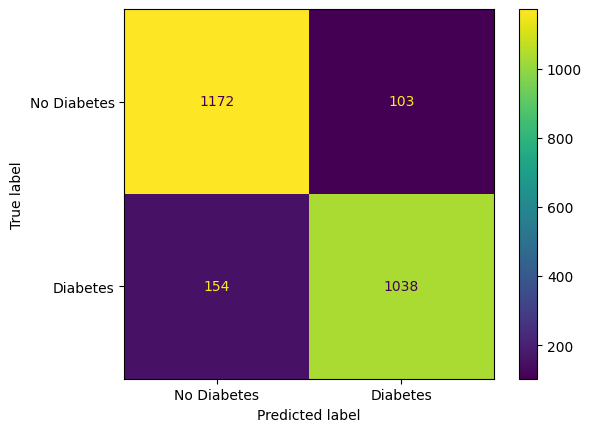

In [49]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Diabetes", "Diabetes"])
disp.plot()
plt.show()

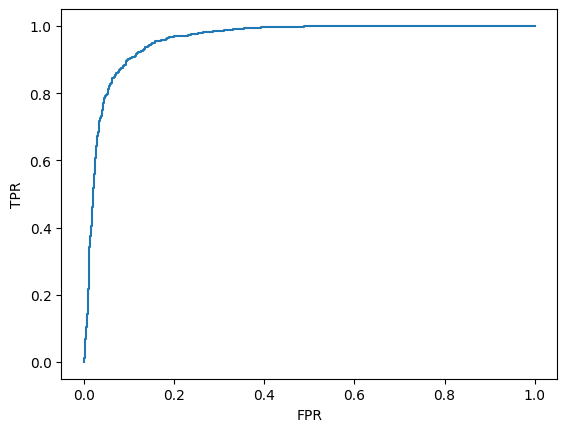

In [50]:
y_pred_proba = lgr.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [51]:
dtc = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    random_state=seed
).fit(X_train, y_train)

y_pred = dtc.predict(X_test)

In [52]:
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))

              precision    recall  f1-score   support

 No Diabetes       0.96      0.92      0.94      1275
    Diabetes       0.92      0.96      0.94      1192

    accuracy                           0.94      2467
   macro avg       0.94      0.94      0.94      2467
weighted avg       0.94      0.94      0.94      2467



In [53]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("ROC AUC score: ", roc_auc_score(y_test, y_pred))

Accuracy: 0.9404134576408594
Precision: 0.9210314262691378
Recall: 0.9588926174496645
F1 score: 0.9395807644882861
ROC AUC score:  0.9410149361758126


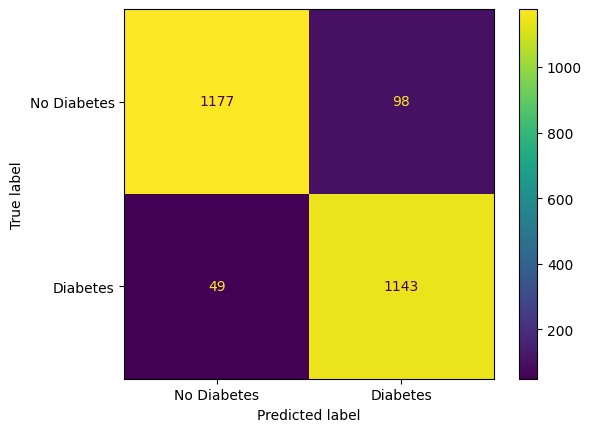

In [54]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Diabetes", "Diabetes"])
disp.plot()
plt.show()

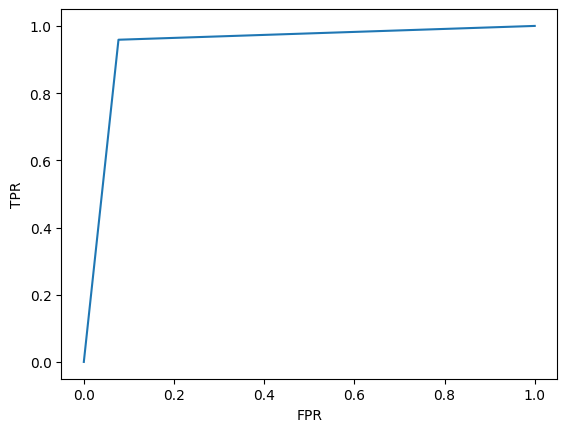

In [55]:
y_pred_proba = dtc.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

[Text(0.4905757498729029, 0.9782608695652174, 'x[2] <= 0.0\ngini = 0.5\nsamples = 9867\nvalue = [4892, 4975]'),
 Text(0.329397559735638, 0.9347826086956522, 'x[9] <= 119.043\ngini = 0.146\nsamples = 4929\nvalue = [4539, 390]'),
 Text(0.40998665480427043, 0.9565217391304348, 'True  '),
 Text(0.18924758515505846, 0.8913043478260869, 'x[0] <= 55.276\ngini = 0.099\nsamples = 4448\nvalue = [4215, 233]'),
 Text(0.0813421453990849, 0.8478260869565217, 'x[9] <= 110.9\ngini = 0.038\nsamples = 3176\nvalue = [3115, 61]'),
 Text(0.0398576512455516, 0.8043478260869565, 'x[0] <= 38.786\ngini = 0.021\nsamples = 2921\nvalue = [2890, 31]'),
 Text(0.013014743263853584, 0.7608695652173914, 'x[11] <= 35.9\ngini = 0.002\nsamples = 1963\nvalue = [1961, 2]'),
 Text(0.006507371631926792, 0.717391304347826, 'x[8] <= 39.25\ngini = 0.001\nsamples = 1943\nvalue = [1942, 1]'),
 Text(0.003253685815963396, 0.6739130434782609, 'gini = 0.0\nsamples = 1914\nvalue = [1914, 0]'),
 Text(0.009761057447890189, 0.67391304347

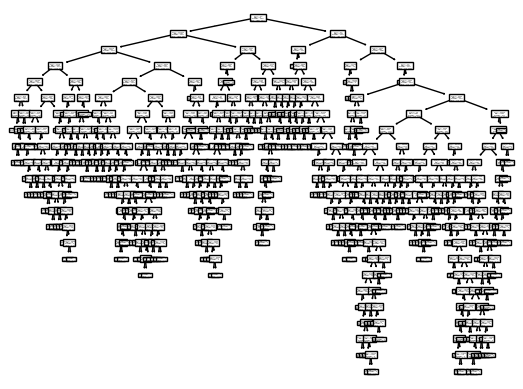

In [56]:
plot_tree(dtc)

In [57]:
rfc = RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    random_state=seed
).fit(X_train, y_train)

y_pred = rfc.predict(X_test)

In [58]:
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))

              precision    recall  f1-score   support

 No Diabetes       0.96      0.97      0.96      1275
    Diabetes       0.97      0.95      0.96      1192

    accuracy                           0.96      2467
   macro avg       0.96      0.96      0.96      2467
weighted avg       0.96      0.96      0.96      2467



In [59]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("ROC AUC score: ", roc_auc_score(y_test, y_pred))

Accuracy: 0.9623023915687069
Precision: 0.9668649107901445
Recall: 0.9546979865771812
F1 score: 0.9607429295061207
ROC AUC score:  0.9620548756415317


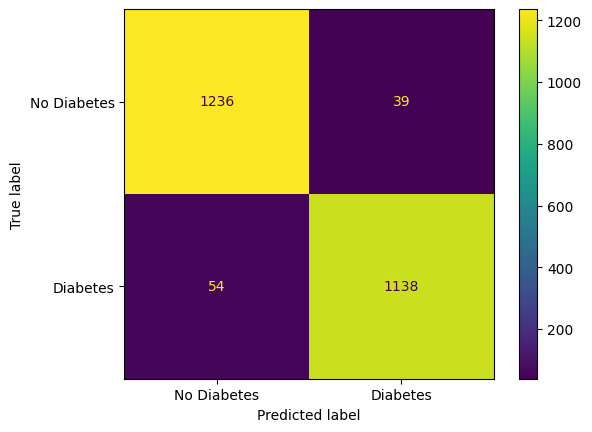

In [60]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Diabetes", "Diabetes"])
disp.plot()
plt.show()

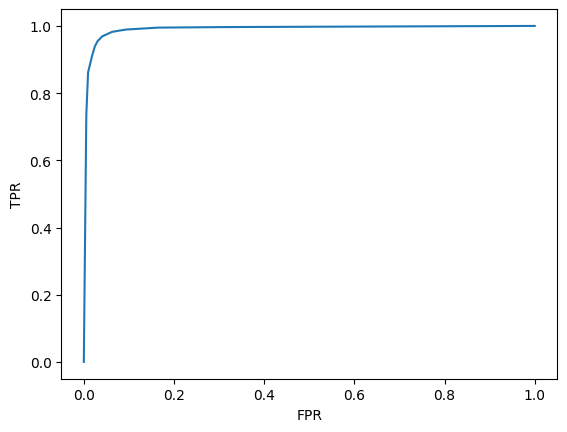

In [61]:
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### Fine-tuning of models: Hyperparamter Optimization

In [62]:
params= {
    'penalty':['l1', 'l2', 'elasticnet'],
    'solver':['lbfgs', 'liblinear', 'newton-cholesky', 'sag'],
    'C':[0.2, 0.4, 0.6, 0.8, 1.0]
}

lgr = GridSearchCV(LogisticRegression(random_state=seed), params)
lgr.fit(X_train, y_train)

c:\Users\jacin\OneDrive - Nanyang Technological University\Desktop\js\ds\env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jacin\OneDrive - Nanyang Technological University\Desktop\js\ds\env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cholesky',
                                    'sag']})

In [63]:
lgr.best_params_

{'C': 0.6, 'penalty': 'l1', 'solver': 'liblinear'}

In [64]:
lgr_ft = lgr.best_estimator_
y_pred = lgr_ft.predict(X_test)

In [65]:
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))

              precision    recall  f1-score   support

 No Diabetes       0.88      0.92      0.90      1275
    Diabetes       0.92      0.87      0.89      1192

    accuracy                           0.90      2467
   macro avg       0.90      0.90      0.90      2467
weighted avg       0.90      0.90      0.90      2467



In [66]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("ROC AUC score: ", roc_auc_score(y_test, y_pred))

Accuracy: 0.8974462910417511
Precision: 0.9151193633952255
Recall: 0.8682885906040269
F1 score: 0.8910891089108911
ROC AUC score:  0.896497236478484


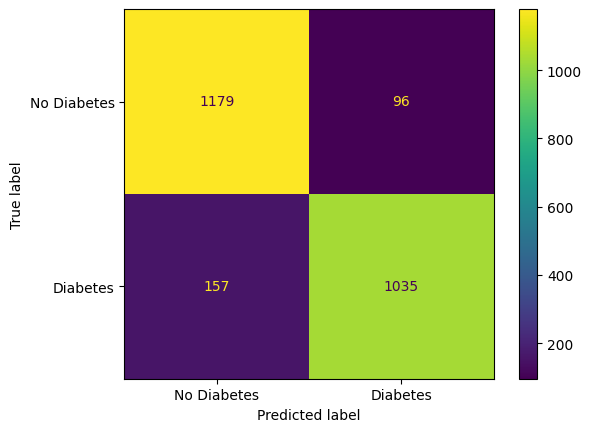

In [67]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Diabetes", "Diabetes"])
disp.plot()
plt.show()

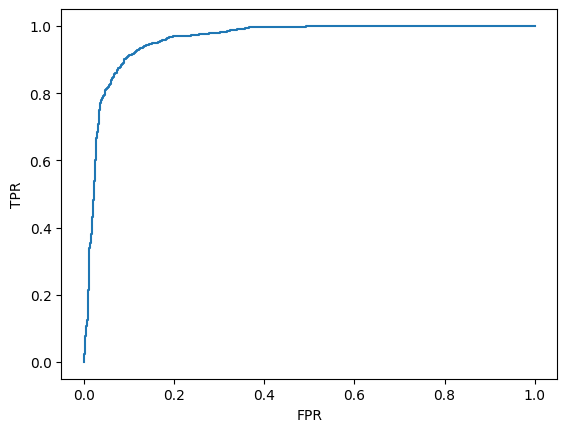

In [68]:
y_pred_proba = lgr_ft.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [69]:
params= {
    'criterion':['gini', 'entropy', 'log_loss'],
    'splitter':['best', 'random'],
    'max_depth':[3, 5, 7]
}

dtc = GridSearchCV(DecisionTreeClassifier(random_state=seed), params)
dtc.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7],
                         'splitter': ['best', 'random']})

In [70]:
dtc.best_params_

{'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}

In [71]:
dtc_ft = dtc.best_estimator_
y_pred = dtc_ft.predict(X_test)

In [72]:
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))

              precision    recall  f1-score   support

 No Diabetes       0.95      0.95      0.95      1275
    Diabetes       0.95      0.95      0.95      1192

    accuracy                           0.95      2467
   macro avg       0.95      0.95      0.95      2467
weighted avg       0.95      0.95      0.95      2467



In [73]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("ROC AUC score: ", roc_auc_score(y_test, y_pred))

Accuracy: 0.9505472233481962
Precision: 0.9495798319327731
Recall: 0.947986577181208
F1 score: 0.9487825356842989
ROC AUC score:  0.950463876825898


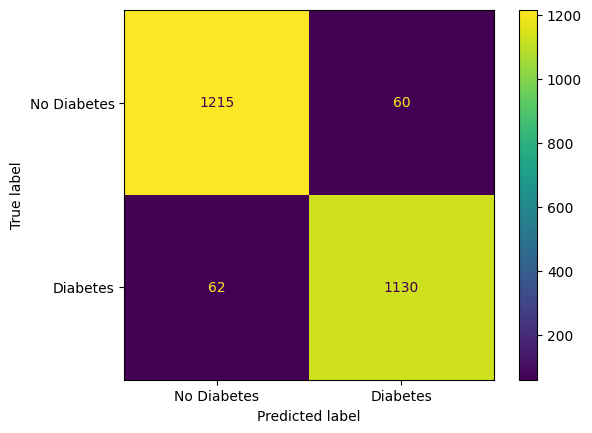

In [74]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Diabetes", "Diabetes"])
disp.plot()
plt.show()

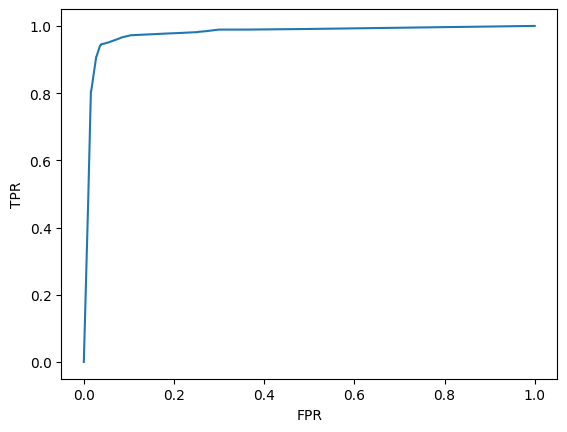

In [75]:
y_pred_proba = dtc_ft.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

[Text(0.6010416666666667, 0.9375, 'x[2] <= 0.0\ngini = 0.5\nsamples = 9867\nvalue = [4892, 4975]'),
 Text(0.37604166666666666, 0.8125, 'x[9] <= 119.043\ngini = 0.146\nsamples = 4929\nvalue = [4539, 390]'),
 Text(0.48854166666666665, 0.875, 'True  '),
 Text(0.21458333333333332, 0.6875, 'x[0] <= 55.276\ngini = 0.099\nsamples = 4448\nvalue = [4215, 233]'),
 Text(0.11666666666666667, 0.5625, 'x[9] <= 110.9\ngini = 0.038\nsamples = 3176\nvalue = [3115, 61]'),
 Text(0.06666666666666667, 0.4375, 'x[0] <= 38.786\ngini = 0.021\nsamples = 2921\nvalue = [2890, 31]'),
 Text(0.03333333333333333, 0.3125, 'x[11] <= 35.9\ngini = 0.002\nsamples = 1963\nvalue = [1961, 2]'),
 Text(0.016666666666666666, 0.1875, 'x[8] <= 39.25\ngini = 0.001\nsamples = 1943\nvalue = [1942, 1]'),
 Text(0.008333333333333333, 0.0625, 'gini = 0.0\nsamples = 1914\nvalue = [1914, 0]'),
 Text(0.025, 0.0625, 'gini = 0.067\nsamples = 29\nvalue = [28, 1]'),
 Text(0.05, 0.1875, 'x[14] <= 0.545\ngini = 0.095\nsamples = 20\nvalue = [19,

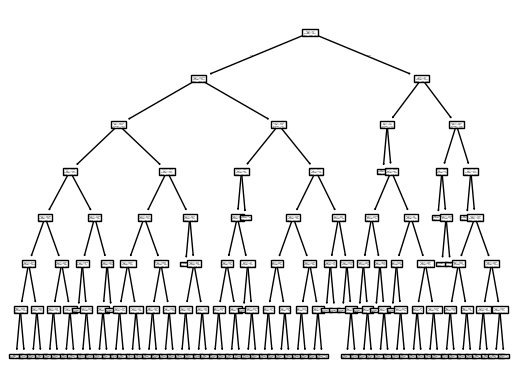

In [76]:
plot_tree(dtc_ft)

In [77]:
params= {
    'n_estimators':[10, 20, 30, 40, 50],
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth':[3, 5, 7]
}

rfc = GridSearchCV(RandomForestClassifier(random_state=seed), params)
rfc.fit(X_train, y_train)

c:\Users\jacin\OneDrive - Nanyang Technological University\Desktop\js\ds\env\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [10, 20, 30, 40, 50]})

In [78]:
rfc.best_params_

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 40}

In [79]:
rfc_ft = rfc.best_estimator_
y_pred = rfc_ft.predict(X_test)

In [80]:
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))

              precision    recall  f1-score   support

 No Diabetes       0.94      0.97      0.95      1275
    Diabetes       0.97      0.93      0.95      1192

    accuracy                           0.95      2467
   macro avg       0.95      0.95      0.95      2467
weighted avg       0.95      0.95      0.95      2467



In [81]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("ROC AUC score: ", roc_auc_score(y_test, y_pred))

Accuracy: 0.9517632752330766
Precision: 0.9693788276465442
Recall: 0.9295302013422819
F1 score: 0.9490364025695931
ROC AUC score:  0.9510396104750626


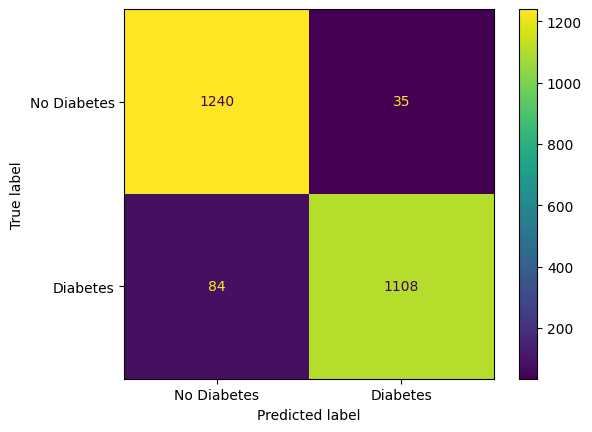

In [82]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Diabetes", "Diabetes"])
disp.plot()
plt.show()

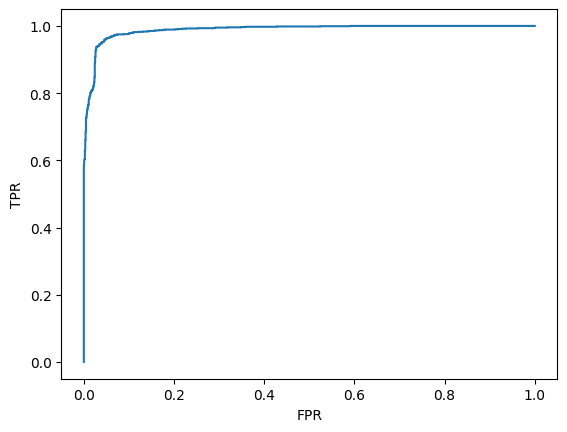

In [83]:
y_pred_proba = rfc_ft.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

After fine-tuning the models, we see that overall all 3 models are able to predict between diabetes and no diabetes (threshold of `gh` >=6.5 as presence of diabetes) very well. In particular, decision tree classifier (DTC) and random forest classifier (RFC) outperform logistic regression (LR), although the difference is not large; performance of DTC and RFC is comparable. 

A possible reason is that DTC and RFC are better able to handle the moderately large number of features in this dataset compared to LR, as decision trees consider features simulatneously and thus consider a reduced feature space at a time whereas LR considers all features collectively and hence does not fare as well on complex data. 

| Model | LR | DTC | RFC |
|:-----:|:--:|:---:|:---:| 
|Accuracy|0.897|0.951|0.952|
|Precision|0.915|0.950|0.969|
|Recall|0.868|0.948|0.930|
|F1 score|0.891|0.949|0.949|   
|AUC score|0.896|0.950|0.951|

Model accuracy tells us if a model is correctly categorizing positive (Diabetes) and negative (No Diabetes) classes and is an indicator of overall performance. F1 score, which takes into account both precision and recall, assesses the models' individual class performance and gives a more comprehensive evaluation especially in the case of imbalanced datasets (which we have balanced beforehand using SMOTE). Since this dataset may have medical diagnostic implications whereby it is serious if someone who has diabetes is predicted to not have it i.e. false negative, F1 score is preferred over accuracy although we have balanced the dataset.